In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
mp_holistic = mp.solutions.holistic #holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities

<h3> preprocess Data and create Label and features </h3>

In [3]:
actions = np.array(['hello', 'thanks','iloveyou','good','seeyoulater', 'learnit','whatisit', 'youarepretty','ithink','itsnothing'])
# actions = np.array(['hello', 'good','iloveyou'])
no_sequences = 50
sequence_length = 20
DATA_PATH = os.path.join('MP_3Data')
label_map = {label:num for num, label in enumerate(actions)}

In [4]:
sequences,labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH,action,str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [5]:
label_map

{'hello': 0,
 'thanks': 1,
 'iloveyou': 2,
 'good': 3,
 'seeyoulater': 4,
 'learnit': 5,
 'whatisit': 6,
 'youarepretty': 7,
 'ithink': 8,
 'itsnothing': 9}

In [6]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X.shape, y.shape

((500, 20, 1662), (500, 10))

In [45]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp,random_state=42)

In [46]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((400, 20, 1662),
 (50, 20, 1662),
 (50, 20, 1662),
 (400, 10),
 (50, 10),
 (50, 10))

In [47]:
actions.shape[0]

10

In [48]:
frame = np.array(sequences).shape[1]
keypoint = np.array(sequences).shape[2]
print(frame, keypoint)


20 1662


In [49]:
model = Sequential()
model.add(LSTM(64, input_shape=(frame, keypoint), return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 20, 64)            442112    
                                                                 
 lstm_10 (LSTM)              (None, 20, 128)           98816     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 10)                330       
                                                                 
Total params: 596906 (2.28 MB)
Trainable params: 59690

In [50]:
tb_callback = TensorBoard(log_dir="Logs\\saved_model4")

In [51]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='categorical_accuracy')

history = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=5000,
          callbacks=[
              tb_callback,
              # ModelCheckpoint('models_normalwithmax/model.h5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto'), 
              ModelCheckpoint('models_normalwithmax2/model-{epoch:02d}-{val_loss:.2f}-{val_categorical_accuracy:.2f}.h5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto'), 
            #   ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.3, patience=200, verbose=1, mode='auto')
              EarlyStopping(monitor='val_loss', mode="min",patience=200, verbose=1)
              ])

Epoch 1/5000
12/13 [==========================>...] - ETA: 0s - loss: 2.5563 - categorical_accuracy: 0.1146
Epoch 1: val_categorical_accuracy improved from -inf to 0.10000, saving model to models_normalwithmax2\model-01-2.46-0.10.h5
13/13 [==============================] - 8s 119ms/step - loss: 2.5479 - categorical_accuracy: 0.1100 - val_loss: 2.4639 - val_categorical_accuracy: 0.1000
Epoch 2/5000
 2/13 [===>..........................] - ETA: 0s - loss: 2.5304 - categorical_accuracy: 0.0781

c:\Users\Zero\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/13 [==========================>...] - ETA: 0s - loss: 2.3938 - categorical_accuracy: 0.1198
Epoch 2: val_categorical_accuracy did not improve from 0.10000
13/13 [==============================] - 1s 63ms/step - loss: 2.3869 - categorical_accuracy: 0.1175 - val_loss: 2.2843 - val_categorical_accuracy: 0.1000
Epoch 3/5000
12/13 [==========================>...] - ETA: 0s - loss: 2.3042 - categorical_accuracy: 0.1224
Epoch 3: val_categorical_accuracy improved from 0.10000 to 0.12000, saving model to models_normalwithmax2\model-03-2.29-0.12.h5
13/13 [==============================] - 1s 62ms/step - loss: 2.3043 - categorical_accuracy: 0.1200 - val_loss: 2.2891 - val_categorical_accuracy: 0.1200
Epoch 4/5000
12/13 [==========================>...] - ETA: 0s - loss: 2.2343 - categorical_accuracy: 0.1771
Epoch 4: val_categorical_accuracy improved from 0.12000 to 0.22000, saving model to models_normalwithmax2\model-04-2.05-0.22.h5
13/13 [==============================] - 1s 64ms/step - loss: 

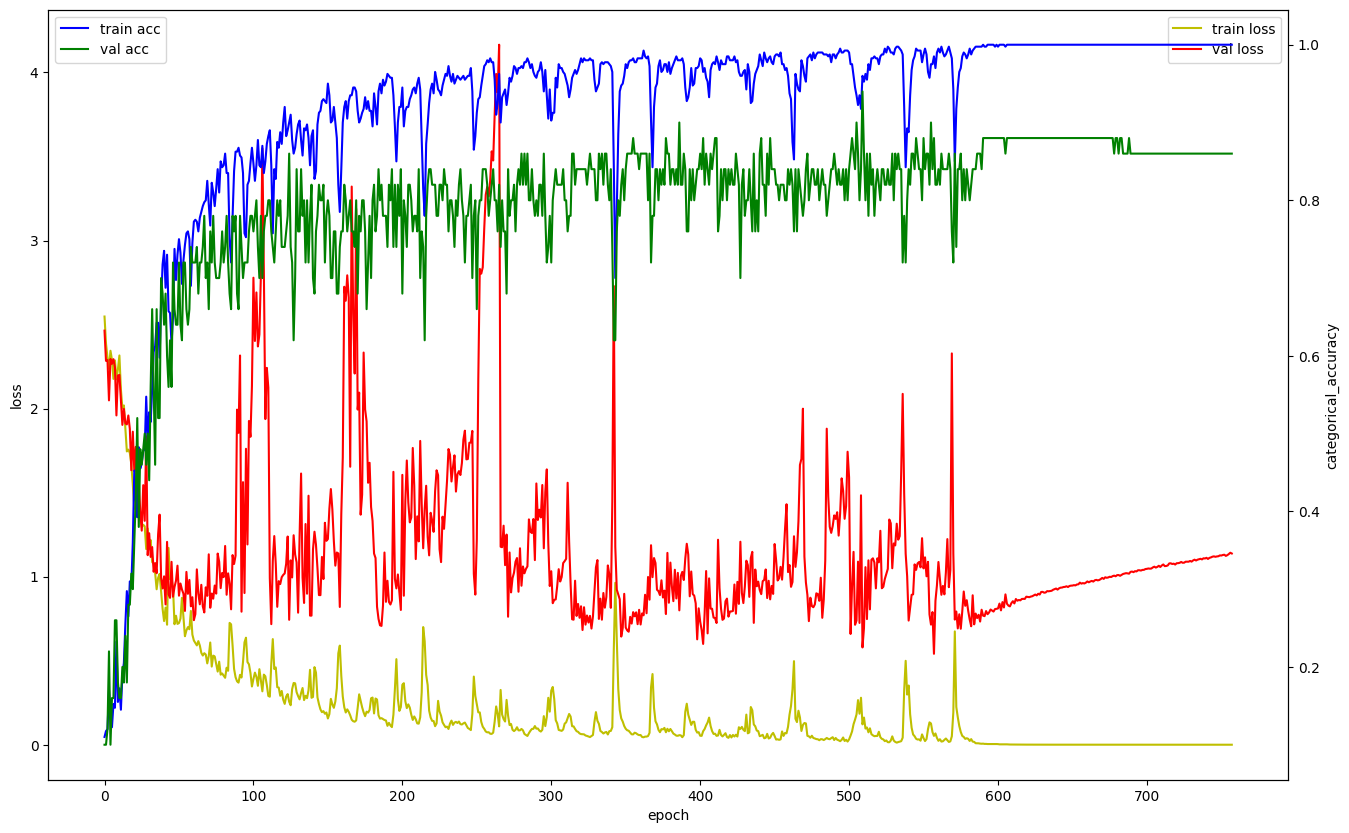

In [52]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc=('upper right'))

acc_ax.plot(history.history['categorical_accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_categorical_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('categorical_accuracy')
acc_ax.legend(loc='upper left')

plt.show()

<h3> Plot Confusion Matrix</h3>

In [53]:
del model 
model = Sequential()
model.add(LSTM(64, input_shape=(frame, keypoint), return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='categorical_accuracy')
# model.load_weights("models_normalwithmax2\model-510-0.58-0.94.h5")

model.save('savedmodel.h5')

model.load_weights('savedmodel.h5')

In [54]:
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
y_hat = model.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()

2/2 [==============================] - 1s 16ms/step


In [56]:
accuracy_score(y_true, y_hat)


0.84

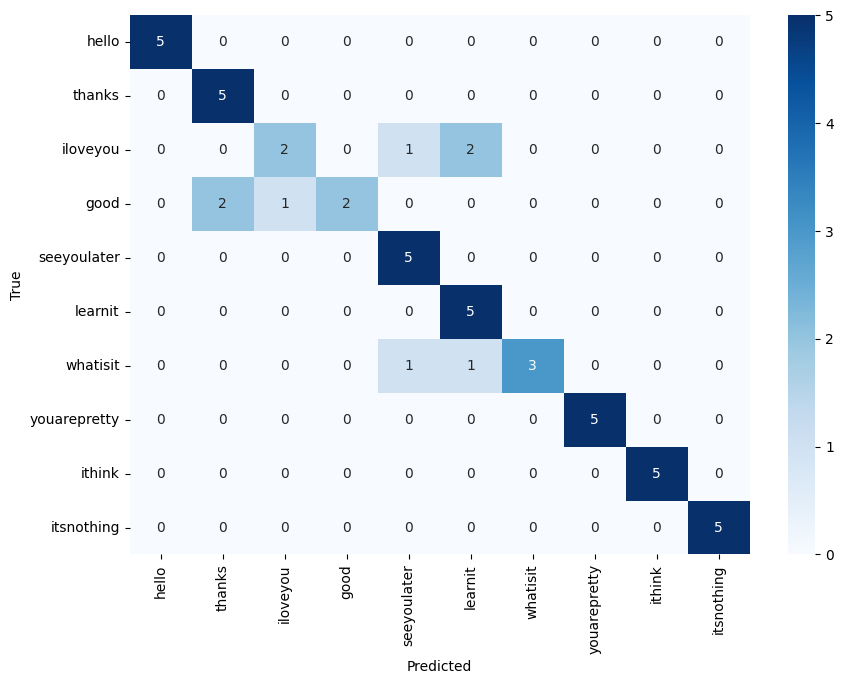

In [58]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_true, y_hat)
class_names = ['hello', 'thanks','iloveyou','good','seeyoulater', 'learnit','whatisit', 'youarepretty','ithink','itsnothing']
plt.figure(figsize=(10,7))
sn.heatmap(conf, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()